In [1]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        
        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes
        
        self.value = None
        
        self.gradients={}
        # keys are the inputs to this node, and their
        # values are the partials of this node with
        # respect to that input.
        #\partial{node}{input_i}
        
    def forward(self):
        '''
        Forward propagation.
        Compute the output value based on 'inbound_nodes' and store the 
        result in self.value
        '''
        raise NotImplemented
        
    def backward(self):
        
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator
        '''
        Node.__init__(self)
    
    def forward(self,value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other nodes implementations should get the value of the 
        previous node from self.inbound_nodes
        Example:
        va10: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value=value
            ## It's is the input node, when need to forward, this node 
            ## initiate self's value.
            
        #Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0} # initialization
        for n in self.outputs:
            grad_cost=n.gradients[self]
            self.gradients[self]= grad_cost * 1
            
        # input N --> N1,N2
        # \partial L / \partial N
        # ==> \partial L / \ partial N1 * \ partial N1 / \partial N
        
class Add(Node):
    def __init__(self,*node):
        Node._init_(self,nodes)
        
    def forward(self):
        slf.value=sum(map(lambda n: n.value,self.inputs))
        ## when execute forward, this node caculate value as defined.
        

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)

    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C        
        
            
def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]
        

In [2]:
losses=[]


In [3]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 158.334
Epoch: 101, Loss: 5.629
Epoch: 201, Loss: 4.894
Epoch: 301, Loss: 3.918
Epoch: 401, Loss: 4.249
Epoch: 501, Loss: 3.559
Epoch: 601, Loss: 3.633
Epoch: 701, Loss: 3.972
Epoch: 801, Loss: 3.751
Epoch: 901, Loss: 2.881
Epoch: 1001, Loss: 3.578
Epoch: 1101, Loss: 3.143
Epoch: 1201, Loss: 3.193
Epoch: 1301, Loss: 3.737
Epoch: 1401, Loss: 3.131
Epoch: 1501, Loss: 3.190
Epoch: 1601, Loss: 3.503
Epoch: 1701, Loss: 3.311
Epoch: 1801, Loss: 3.327
Epoch: 1901, Loss: 3.367
Epoch: 2001, Loss: 2.848
Epoch: 2101, Loss: 3.886
Epoch: 2201, Loss: 3.843
Epoch: 2301, Loss: 3.026
Epoch: 2401, Loss: 3.550
Epoch: 2501, Loss: 2.837
Epoch: 2601, Loss: 2.913
Epoch: 2701, Loss: 3.123
Epoch: 2801, Loss: 2.951
Epoch: 2901, Loss: 3.040
Epoch: 3001, Loss: 3.056
Epoch: 3101, Loss: 2.830
Epoch: 3201, Loss: 2.566
Epoch: 3301, Loss: 2.917
Epoch: 3401, Loss: 3.043
Epoch: 3501, Loss: 3.548
Epoch: 3601, Loss: 3.452
Epoch: 3701, Loss: 2.372
Epoch: 3801, Loss: 2.785
Epoc

In [4]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [5]:
forward(l2,graph)

array([[16.00126385],
       [20.04825774],
       [21.56174855],
       [28.21346652],
       [35.52771533],
       [34.02598432],
       [27.75469189],
       [22.16418034],
       [16.5137296 ],
       [19.33326527],
       [22.19478324],
       [18.86526944],
       [19.66234174],
       [23.67735045],
       [21.20817456],
       [ 8.43480746]])

In [6]:
import matplotlib.pyplot as plt

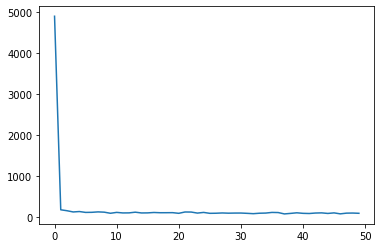

In [9]:
plt.plot(range(len(losses)),losses)


In [10]:
W2.value

array([[ 4.50172922],
       [ 7.89559892],
       [21.98510882],
       [ 6.12256685],
       [ 8.12591668],
       [ 4.96416275],
       [ 5.0883343 ],
       [ 6.10847279],
       [ 4.67252841],
       [13.61401602]])

In [11]:
X_=data['data']

In [12]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [13]:
import keras

Using TensorFlow backend.


In [17]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [18]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [19]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 915us/step - loss: 156.7410 - mse: 156.7410
Epoch 2/5000
506/506 [==============================] - 0s 310us/step - loss: 82.0108 - mse: 82.0108
Epoch 3/5000
506/506 [==============================] - 0s 208us/step - loss: 80.9755 - mse: 80.9755
Epoch 4/5000
506/506 [==============================] - 0s 166us/step - loss: 81.6111 - mse: 81.6112
Epoch 5/5000
506/506 [==============================] - 0s 204us/step - loss: 85.0044 - mse: 85.0044
Epoch 6/5000
506/506 [==============================] - 0s 206us/step - loss: 82.7118 - mse: 82.7118
Epoch 7/5000
506/506 [==============================] - 0s 178us/step - loss: 85.9300 - mse: 85.9300
Epoch 8/5000
506/506 [==============================] - 0s 186us/step - loss: 83.5978 - mse: 83.5978
Epoch 9/5000
506/506 [==============================] - 0s 208us/step - loss: 83.6346 - mse: 83.6346
Epoch 10/5000
506/506 [==============================] - 0s 170us/step - loss: 84.6123 - 

506/506 [==============================] - 0s 516us/step - loss: 77.6653 - mse: 77.6653
Epoch 81/5000
506/506 [==============================] - 0s 269us/step - loss: 77.8771 - mse: 77.8771
Epoch 82/5000
506/506 [==============================] - 0s 285us/step - loss: 78.6037 - mse: 78.6037
Epoch 83/5000
506/506 [==============================] - 0s 251us/step - loss: 83.9400 - mse: 83.9400A: 0s - loss: 70.4088 - mse: 70.4088
Epoch 84/5000
506/506 [==============================] - 0s 223us/step - loss: 86.2535 - mse: 86.2535
Epoch 85/5000
506/506 [==============================] - 0s 204us/step - loss: 85.9040 - mse: 85.9040
Epoch 86/5000
506/506 [==============================] - 0s 356us/step - loss: 84.6735 - mse: 84.6735
Epoch 87/5000
506/506 [==============================] - 0s 298us/step - loss: 85.0787 - mse: 85.0787
Epoch 88/5000
506/506 [==============================] - 0s 289us/step - loss: 85.3281 - mse: 85.3281
Epoch 89/5000
506/506 [==============================] - 0s 

506/506 [==============================] - 0s 245us/step - loss: 84.9340 - mse: 84.9340
Epoch 159/5000
506/506 [==============================] - 0s 267us/step - loss: 84.5298 - mse: 84.5298
Epoch 160/5000
506/506 [==============================] - 0s 164us/step - loss: 84.9384 - mse: 84.9384
Epoch 161/5000
506/506 [==============================] - 0s 134us/step - loss: 84.8187 - mse: 84.8187
Epoch 162/5000
506/506 [==============================] - 0s 180us/step - loss: 84.6082 - mse: 84.6082
Epoch 163/5000
506/506 [==============================] - 0s 209us/step - loss: 85.1761 - mse: 85.1761
Epoch 164/5000
506/506 [==============================] - 0s 277us/step - loss: 85.2290 - mse: 85.2290A: 0s - loss: 90.6482 - mse: 90.6482
Epoch 165/5000
506/506 [==============================] - 0s 215us/step - loss: 84.6696 - mse: 84.6695
Epoch 166/5000
506/506 [==============================] - 0s 188us/step - loss: 85.2769 - mse: 85.2769
Epoch 167/5000
506/506 [============================

506/506 [==============================] - 0s 838us/step - loss: 84.9088 - mse: 84.9088 0s - loss: 90.0188 - mse: 90.01
Epoch 237/5000
506/506 [==============================] - 0s 680us/step - loss: 85.3100 - mse: 85.3100
Epoch 238/5000
506/506 [==============================] - 0s 947us/step - loss: 84.8953 - mse: 84.8953
Epoch 239/5000
506/506 [==============================] - 0s 559us/step - loss: 84.5551 - mse: 84.5552
Epoch 240/5000
506/506 [==============================] - 0s 878us/step - loss: 85.0080 - mse: 85.0080
Epoch 241/5000
506/506 [==============================] - 0s 304us/step - loss: 84.8541 - mse: 84.8541
Epoch 242/5000
506/506 [==============================] - 0s 609us/step - loss: 85.1293 - mse: 85.1293
Epoch 243/5000
506/506 [==============================] - 0s 603us/step - loss: 85.7119 - mse: 85.7119
Epoch 244/5000
506/506 [==============================] - 0s 733us/step - loss: 84.8372 - mse: 84.8372
Epoch 245/5000
506/506 [==============================] 

506/506 [==============================] - 0s 389us/step - loss: 84.9057 - mse: 84.9057
Epoch 315/5000
506/506 [==============================] - 0s 219us/step - loss: 85.0015 - mse: 85.0015
Epoch 316/5000
506/506 [==============================] - 0s 97us/step - loss: 85.1142 - mse: 85.1142
Epoch 317/5000
506/506 [==============================] - 0s 105us/step - loss: 85.3524 - mse: 85.3524
Epoch 318/5000
506/506 [==============================] - ETA: 0s - loss: 84.9326 - mse: 84.932 - 0s 140us/step - loss: 84.7800 - mse: 84.7800
Epoch 319/5000
506/506 [==============================] - 0s 111us/step - loss: 84.3976 - mse: 84.3976
Epoch 320/5000
506/506 [==============================] - ETA: 0s - loss: 80.4828 - mse: 80.482 - 0s 180us/step - loss: 85.1337 - mse: 85.1337
Epoch 321/5000
506/506 [==============================] - 0s 142us/step - loss: 84.9513 - mse: 84.9513
Epoch 322/5000
506/506 [==============================] - 0s 150us/step - loss: 84.6219 - mse: 84.6219
Epoch 323

506/506 [==============================] - 0s 200us/step - loss: 84.9419 - mse: 84.9419
Epoch 392/5000
506/506 [==============================] - 0s 142us/step - loss: 85.1006 - mse: 85.1006
Epoch 393/5000
506/506 [==============================] - 0s 101us/step - loss: 85.0953 - mse: 85.0953
Epoch 394/5000
506/506 [==============================] - 0s 103us/step - loss: 84.8499 - mse: 84.8499
Epoch 395/5000
506/506 [==============================] - 0s 113us/step - loss: 85.0009 - mse: 85.0009
Epoch 396/5000
506/506 [==============================] - 0s 138us/step - loss: 85.3548 - mse: 85.3548
Epoch 397/5000
506/506 [==============================] - 0s 105us/step - loss: 84.8531 - mse: 84.8531
Epoch 398/5000
506/506 [==============================] - 0s 113us/step - loss: 84.8729 - mse: 84.8729
Epoch 399/5000
506/506 [==============================] - 0s 140us/step - loss: 85.4809 - mse: 85.4809
Epoch 400/5000
506/506 [==============================] - 0s 132us/step - loss: 84.8088 

506/506 [==============================] - 0s 247us/step - loss: 85.6422 - mse: 85.6422
Epoch 470/5000
506/506 [==============================] - 0s 140us/step - loss: 84.9921 - mse: 84.9921
Epoch 471/5000
506/506 [==============================] - 0s 99us/step - loss: 85.7303 - mse: 85.7303
Epoch 472/5000
506/506 [==============================] - 0s 121us/step - loss: 85.2727 - mse: 85.2727
Epoch 473/5000
506/506 [==============================] - 0s 136us/step - loss: 85.2612 - mse: 85.2612
Epoch 474/5000
506/506 [==============================] - 0s 109us/step - loss: 85.2132 - mse: 85.2132
Epoch 475/5000
506/506 [==============================] - 0s 107us/step - loss: 84.9675 - mse: 84.9675
Epoch 476/5000
506/506 [==============================] - 0s 99us/step - loss: 85.2050 - mse: 85.2050
Epoch 477/5000
506/506 [==============================] - 0s 128us/step - loss: 84.6212 - mse: 84.6213
Epoch 478/5000
506/506 [==============================] - 0s 103us/step - loss: 84.7193 - 

KeyboardInterrupt: 